# Working with sequences 

## Sequence to sequence example in Keras. (adapted from [Keras Blog](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html))

### Imports and parameters

In [29]:
from __future__ import print_function

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import RMSprop
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
batch_size = 64  # Batch size for training.
epochs = 5  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'heb.txt'

### Vectorize the data and prepare training/test sets.

We will turn the sentences into three Numpy arrays: encoder_input_data, decoder_input_data, decoder_target_data.

**encoder_input_data** is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.

**decoder_input_data** is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the Hebrew sentences.

**decoder_target_data** is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

In [14]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [15]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 68
Number of unique output tokens: 60
Max sequence length for inputs: 15
Max sequence length for outputs: 37


In [16]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [17]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [18]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

### Build the model

In [19]:
from keras import regularizers as rglz
from keras.layers import Bidirectional

In [20]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')# ,kernel_regularizer=rglz.l2(0.01))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [21]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

In [25]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[EarlyStopping(patience=3, verbose=1), ReduceLROnPlateau(patience=1, min_lr=10e-6, verbose=1)],
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 34s 4ms/step - loss: 0.7900 - val_loss: 0.8739
Epoch 2/5
8000/8000 [==============================] - 33s 4ms/step - loss: 0.7100 - val_loss: 0.8267
Epoch 3/5
8000/8000 [==============================] - 31s 4ms/step - loss: 0.6642 - val_loss: 0.7805
Epoch 4/5
8000/8000 [==============================] - 31s 4ms/step - loss: 0.6279 - val_loss: 0.7488
Epoch 5/5
8000/8000 [==============================] - 35s 4ms/step - loss: 0.5974 - val_loss: 0.7359


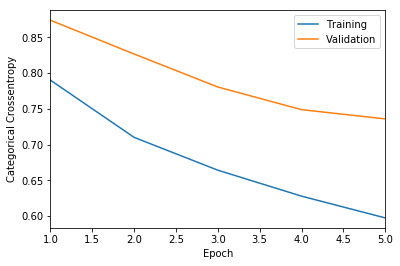

In [26]:
history = model.history
fig, ax = plt.subplots(1, 1)
ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='Training')
ax.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'], label='Validation')
ax.legend(loc='upper right')
ax.set_xlim(1, epochs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Categorical Crossentropy')
plt.show()

In [116]:
# Save model
model.save('tmp')

/home/thras/.pyenv/versions/3.5.2/envs/structural-comet-py352/lib/python3.5/site-packages/keras/engine/topology.py:2364: UserWarning: Layer cu_dnnlstm_12 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_11/strided_slice_16:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'cu_dnnlstm_11/strided_slice_17:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [30]:
model = load_model('s2s_eng_heb_30e.h5')

### Inference mode (sampling).
Here's the drill:

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state and a "start of sequence" token as target.Output will be the next target token
3. Repeat with the current target token and current states

In [31]:
def decode_sequence(input_seq, encoder_model, decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [32]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [33]:
test_texts_1 = ['Thanks.', 'Hello.', 'How are you?']

In [34]:
test_texts_2 = [input_texts[i] for i in random.sample(range(len(input_texts)), 10)]

In [35]:
def encode_texts_to_1hot_seq(input_texts):
    input_seq = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for i, text in enumerate(input_texts):
        for t, char in enumerate(text):
            input_seq[i, t, input_token_index[char]] = 1.
    return input_seq

In [36]:
for test_text in test_texts_1:
    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = encode_texts_to_1hot_seq([test_text])
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model)
    print('-')
    print('Input sentence:', test_text)
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Thanks.
Decoded sentence: תחו את זה.

-
Input sentence: Hello.
Decoded sentence: תחיי את זה.

-
Input sentence: How are you?
Decoded sentence: איה אתה את זה.



In [37]:
for test_text in test_texts_2:
    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = encode_texts_to_1hot_seq([test_text])
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model)
    print('-')
    print('Input sentence:', test_text)
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Let's try.
Decoded sentence: תום היה לאות.

-
Input sentence: Don't be a pig.
Decoded sentence: את תריה את זה.

-
Input sentence: It's new.
Decoded sentence: זה היה משור.

-
Input sentence: It's time.
Decoded sentence: זה היה משור.

-
Input sentence: Isn't it flat?
Decoded sentence: זה היה משור.

-
Input sentence: Wait a while.
Decoded sentence: תחזה את זה.

-
Input sentence: He can swim.
Decoded sentence: הוא היה מסור.

-
Input sentence: Want a drink?
Decoded sentence: אתה נואה את זה.

-
Input sentence: Tom retired.
Decoded sentence: תום משור.

-
Input sentence: He seems happy.
Decoded sentence: הוא היה מסור.



## Biological Sequences: DNA and proteins

In [38]:
import evolutron.tools as et

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

### Transforming the protein/DNA sequences into an 1-hot representation

In [40]:
amino_acids = list(et.aa_map.keys())

In [41]:
aa_seq = 'MASGKFITFEGIDGAGKTTHLQWFCERLQAKLAAGGRQVVVTREPGGTQLGEKLREILLN \
          QPMDLETEAL LMFAARREHL ALVIEPALAR GDWVVSDRFT DATFAYQGGG RGLPRDKLET \
          LERWVQGGFQ PDLTVLFDVA PQVASERRGA VRMPDKFESE SDAFFSRTRG EYLRRAEEAP \
          HRFAIVDATQ SIPEIRQQLE RVLAAL'.replace(' ','')
aa_hot = et.aa2hot(aa_seq)

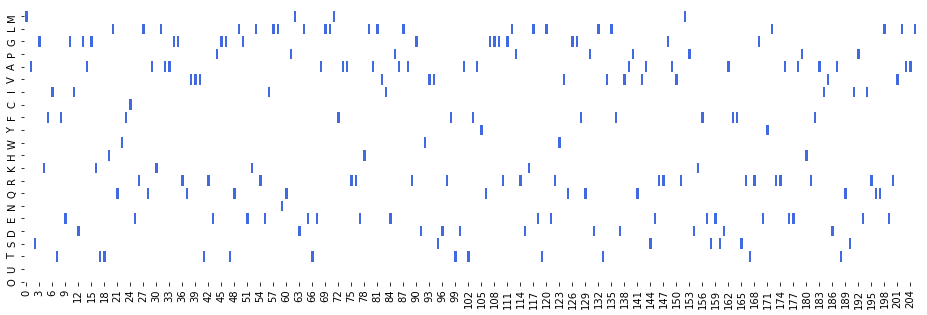

In [42]:
fig, ax = plt.subplots(1,1, figsize=(16,5)) 
sns.heatmap(aa_hot.T, ax=ax, yticklabels=amino_acids, linewidths=1, cmap=['white', 'royalblue'], cbar=False)
plt.show()

In [43]:
dna_seq = 'GTAYGGGRTN'
dna_hot = et.nt2prob(dna_seq)

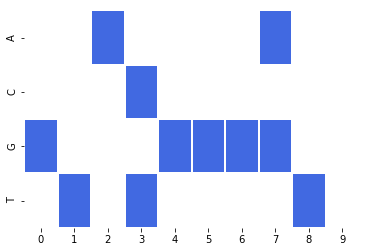

In [44]:
fig, ax = plt.subplots(1,1) 
sns.heatmap(dna_hot.T, ax=ax, yticklabels=['A','C','G','T'], linewidths=1, cmap=['white', 'royalblue'], cbar=False)
plt.show()

### Creating a dataset for protein translation

In [45]:
import pandas as pd